In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORTS and Loading-in Dataset

In [3]:
# IMPORTS
import json
import torch
from transformers import (
    LongformerTokenizer,
    LongformerForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

df = pd.read_csv('/content/drive/My Drive/Political_Bias.csv')
df.columns = df.columns.str.lower()
print('Initial Label counts: \n', df['bias'].value_counts(), '\n')
print('Number of samples: ', len(df))
df.describe()

Initial Label counts: 
 bias
left          1865
lean left      534
right          529
center         319
lean right     211
Name: count, dtype: int64 

Number of samples:  3458


,title,link,text,source,bias
count,3458,3458,3397,3458,3458
unique,3210,2908,2435,21,5
top,Trumpâ€™s Supposed Unity Message Is a Gloating...,https://www.thenation.com/article/politics/tru...,Error fetching article,Alternet,left
freq,7,7,632,1031,1865


# Data Preprocessing and Tokenisation

In [13]:
# Remove irrelevant columns
df = df.drop('link', axis=1)
df = df.drop('title', axis=1)
df = df.drop('source', axis=1)

# Drop rows where:
df.dropna(inplace=True) # there are missing values
df = df[df['text'] != 'Error fetching article'] # the text is an error message
df.drop_duplicates(subset='text', keep='first', inplace=True) # the text is duplicated
df = df[df['text'].str.strip() != ''] # the text is empty or only whitespace

df['length'] = df['text'].apply(lambda x: len(x.split(' ')))
df = df[df['length'] >= 15] # the text is too short

df = df[df['length'] <= 2048] # the text is too long

# LABEL ENCODING AND DATAFRAME PREPARATION
id2label = {0: "left", 1: "lean left", 2: "center", 3: "lean right", 4: "right"}
label2id = {v: k for k, v in id2label.items()}
# model.config.id2label = id2label
# model.config.label2id = label2id

df['label'] = df['bias'].map(label2id) # Convert bias labels to numeric
df = df[['text', 'bias', 'label']] # Keep only relevant columns

# TRAIN/VAL/TEST SPLIT
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']  # Keep class distribution
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']  # Keep class distribution
)

print(f"\nSplit sizes:")
print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print('Train Label counts: \n', train_df['bias'].value_counts(), '\n')
print(f"Val: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print('Val Label counts: \n', val_df['bias'].value_counts(), '\n')
print(f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
print('Test Label counts: \n', test_df['bias'].value_counts(), '\n')

# CONVERT TO HUGGING FACE DATASET
train_dataset = Dataset.from_pandas(train_df[['text', 'label']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['text', 'label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['text', 'label']].reset_index(drop=True))

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# LOAD MODEL AND TOKENIZER
model_name = "allenai/longformer-base-4096"
tokenizer = LongformerTokenizer.from_pretrained(model_name)

model = LongformerForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    id2label=id2label,
    label2id=label2id,
    problem_type="single_label_classification"
)

# TOKENIZE DATASET
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        max_length=2048,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text']  # Remove text, keep only input_ids, attention_mask, label
)

tokenized_dataset.set_format("torch")
print("\nTokenized dataset:")
print(tokenized_dataset)

# COMPUTE CLASS WEIGHTS (for imbalance)
class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1, 2, 3, 4]),
    y=train_df['label'].values
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print("\nClass weights:")
for label, weight in zip(id2label.values(), class_weights):
    print(f"  {label}: {weight:.3f}")


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1890 [00:00<?, ? examples/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]


Tokenized dataset:
DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1890
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 236
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 237
    })
})

Class weights:
  left: 0.398
  lean left: 1.518
  center: 2.362
  lean right: 2.520
  right: 0.990


In [10]:
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device) if class_weights is not None else None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Helper Evaluation Functions

In [5]:
def compute_metrics(eval_pred):
    """Metrics computed during training"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate all metrics
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)

    # Per-class F1
    f1_per_class = f1_score(labels, predictions, average=None, zero_division=0)

    metrics = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,           # PRIMARY METRIC
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
    }

    # Add per-class F1s
    label_names = ['left', 'right', 'lean left', 'center', 'lean right']
    for i, name in enumerate(label_names):
        metrics[f'f1_{name}'] = f1_per_class[i]

    return metrics

def plot_confusion_matrix(true_labels, predictions, label_names, save_path='confusion_matrix.png'):
    """Plot normalized confusion matrix"""
    cm = confusion_matrix(true_labels, predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2%',
        cmap='Blues',
        xticklabels=label_names,
        yticklabels=label_names,
        cbar_kws={'label': 'Percentage'}
    )
    plt.title('Confusion Matrix (Normalized by True Label)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix saved to {save_path}")
    plt.show()

def analyze_directional_errors(true_labels, predictions, label2id):
    """Analyze political spectrum directional errors"""
    spectrum_order = ['left', 'lean left', 'center', 'lean right', 'right']
    id_to_position = {label2id[l]: i for i, l in enumerate(spectrum_order)}

    errors = []
    for true, pred in zip(true_labels, predictions):
        if true != pred:
            true_pos = id_to_position[true]
            pred_pos = id_to_position[pred]
            distance = abs(true_pos - pred_pos)
            errors.append(distance)

    if errors:
        avg_error_distance = np.mean(errors)
        opposite_errors = sum(1 for d in errors if d >= 3)

        print(f"\nDIRECTIONAL ERROR ANALYSIS:")
        print(f"  Average error distance: {avg_error_distance:.2f}")
        print(f"  (1.0 = adjacent class, 4.0 = opposite end)")
        print(f"  Opposite-end errors: {opposite_errors}/{len(errors)} ({opposite_errors/len(errors)*100:.1f}%)")
        print(f"  Adjacent errors: {sum(1 for d in errors if d == 1)}/{len(errors)} ({sum(1 for d in errors if d == 1)/len(errors)*100:.1f}%)")
    else:
        print("\nPerfect predictions - no errors!")

def full_evaluation(trainer, test_dataset, label_names, label2id, save_prefix=""):
    """Complete evaluation after training"""

    print("\n" + "="*70)
    print("FINAL MODEL EVALUATION")
    print("="*70)

    # Get predictions
    predictions_output = trainer.predict(test_dataset)
    predictions = np.argmax(predictions_output.predictions, axis=1)
    true_labels = predictions_output.label_ids

    # Overall metrics
    print("\nOVERALL METRICS:")
    accuracy = accuracy_score(true_labels, predictions)
    f1_macro = f1_score(true_labels, predictions, average='macro')
    f1_weighted = f1_score(true_labels, predictions, average='weighted')
    precision_macro = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(true_labels, predictions, average='macro', zero_division=0)

    print(f"  Accuracy:          {accuracy:.4f}")
    print(f"  F1-Macro:          {f1_macro:.4f} -> PRIMARY METRIC")
    print(f"  F1-Weighted:       {f1_weighted:.4f}")
    print(f"  Precision-Macro:   {precision_macro:.4f}")
    print(f"  Recall-Macro:      {recall_macro:.4f}")

    # Per-class F1
    f1_per_class = f1_score(true_labels, predictions, average=None, zero_division=0)
    print(f"\nPER-CLASS F1 SCORES:")
    for i, name in enumerate(label_names):
        print(f"  {name:12}: {f1_per_class[i]:.4f}")

    # Classification report
    print("\n" + "="*70)
    print("DETAILED CLASSIFICATION REPORT:")
    print("="*70)
    print(classification_report(
        true_labels,
        predictions,
        target_names=label_names,
        digits=4
    ))

    # Confusion matrix
    print("\n" + "="*70)
    print("CONFUSION MATRIX:")
    print("="*70)
    plot_confusion_matrix(
        true_labels,
        predictions,
        label_names,
        save_path=f'{save_prefix}confusion_matrix.png'
    )

    # Directional errors
    analyze_directional_errors(true_labels, predictions, label2id)

    # Find high-confidence mistakes
    probs = torch.nn.functional.softmax(torch.tensor(predictions_output.predictions), dim=-1)
    confidence = probs.max(dim=1).values.numpy()

    mistakes = predictions != true_labels
    high_conf_mistakes = mistakes & (confidence > 0.8)

    print(f"\nHIGH-CONFIDENCE MISTAKES:")
    print(f"  Total mistakes: {mistakes.sum()}")
    print(f"  High-confidence mistakes (>80%): {high_conf_mistakes.sum()}")
    if high_conf_mistakes.sum() > 0:
        print(f"  (These are worth manually inspecting)")

    # Return summary
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_per_class': dict(zip(label_names, f1_per_class)),
        'total_errors': int(mistakes.sum()),
        'high_conf_errors': int(high_conf_mistakes.sum())
    }

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f"\nUsing device: {device}")

# Move model to device
model.to(device)

results1 = {}


Using device: cuda


In [11]:
results1

{'full': {'accuracy': 0.8438818565400844,
  'f1_macro': 0.7490985198580136,
  'f1_weighted': 0.836517403403052,
  'precision_macro': 0.800581676024558,
  'recall_macro': 0.742119423321111,
  'f1_per_class': {'left': np.float64(0.919831223628692),
   'lean left': np.float64(0.8),
   'center': np.float64(0.65),
   'lean right': np.float64(0.5185185185185185),
   'right': np.float64(0.8571428571428571)},
  'total_errors': 37,
  'high_conf_errors': 26,
  'training_time_minutes': 73.56790949900945}}

# Full Fine-tuning


STARTING TRAINING...



Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,F1 Left,F1 Right,F1 Lean left,F1 Center,F1 Lean right
1,1.153400,0.952814,0.682203,0.538966,0.676269,0.577445,0.549863,0.829493,0.758621,0.562500,0.000000,0.544218
2,0.628400,0.674362,0.872881,0.798963,0.862732,0.913221,0.748839,0.911197,0.896552,0.742857,0.560000,0.884211
3,0.414700,0.640692,0.872881,0.801056,0.868355,0.828729,0.799665,0.933884,0.857143,0.782609,0.571429,0.860215



full-fine-tuning complete! Time: 75.73 minutes

Evaluating on test set...


FINAL MODEL EVALUATION



OVERALL METRICS:
  Accuracy:          0.8565
  F1-Macro:          0.7619 -> PRIMARY METRIC
  F1-Weighted:       0.8469
  Precision-Macro:   0.8171
  Recall-Macro:      0.7597

PER-CLASS F1 SCORES:
  left        : 0.9244
  lean left   : 0.8182
  center      : 0.7317
  lean right  : 0.4615
  right       : 0.8738

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        left     0.9244    0.9244    0.9244       119
   lean left     0.7714    0.8710    0.8182        31
      center     0.7143    0.7500    0.7317        20
  lean right     0.8571    0.3158    0.4615        19
       right     0.8182    0.9375    0.8738        48

    accuracy                         0.8565       237
   macro avg     0.8171    0.7597    0.7619       237
weighted avg     0.8597    0.8565    0.8469       237


CONFUSION MATRIX:
Confusion matrix saved to full_confusion_matrix.png


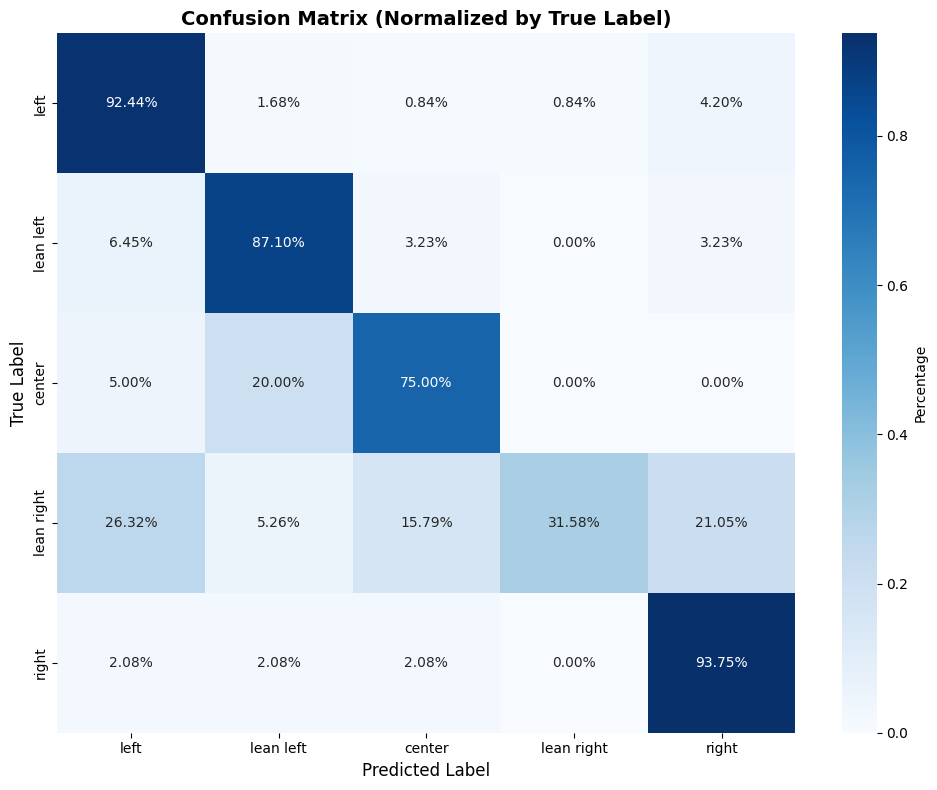


DIRECTIONAL ERROR ANALYSIS:
  Average error distance: 2.12
  (1.0 = adjacent class, 4.0 = opposite end)
  Opposite-end errors: 14/34 (41.2%)
  Adjacent errors: 16/34 (47.1%)

HIGH-CONFIDENCE MISTAKES:
  Total mistakes: 34
  High-confidence mistakes (>80%): 16
  (These are worth manually inspecting)
{
  "accuracy": 0.8565400843881856,
  "f1_macro": 0.7619167504919202,
  "f1_weighted": 0.846872409481629,
  "precision_macro": 0.8170817417876242,
  "recall_macro": 0.7597253927037708,
  "f1_per_class": {
    "left": 0.9243697478991597,
    "lean left": 0.8181818181818182,
    "center": 0.7317073170731707,
    "lean right": 0.46153846153846156,
    "right": 0.8737864077669902
  },
  "total_errors": 34,
  "high_conf_errors": 16,
  "training_time_minutes": 75.73055998484294
}


In [14]:
training_args = TrainingArguments(
    output_dir="./longformer_political_bias",

    # Memory-optimized settings
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,

    # Memory optimizations
    gradient_checkpointing=True,  # CRITICAL for memory
    fp16=True,
    dataloader_num_workers=0,  # Reduce from 2
    dataloader_pin_memory=False,

    # Evaluation & saving
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    # Logging
    logging_dir="./logs",
    logging_steps=50,
    logging_strategy="steps",

    # Other
    seed=42,
    report_to="none",
    save_total_limit=1,  # Keep only 1 checkpoint to save disk space
)

# Enable gradient checkpointing on model
model.gradient_checkpointing_enable()

# INITIALIZE TRAINER
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

print("\n" + "="*70)
print("STARTING TRAINING...")
print("="*70 + "\n")
start_time = time.time()

trainer.train()

full_time = time.time() - start_time
print(f"\nfull-fine-tuning complete! Time: {full_time/60:.2f} minutes")

print("\n" + "="*50)
print("Evaluating on test set...")
print("="*50 + "\n")

label_names = list(id2label.values())
full_metrics = full_evaluation(
    trainer,
    tokenized_dataset['test'],
    label_names,
    label2id,
    save_prefix="full_"
) # list(id2label.values()), label2id,

trainer.save_model("./longformer_full_model")
tokenizer.save_pretrained("./longformer_full_model")

full_metrics['training_time_minutes'] = full_time / 60

results1['full'] = full_metrics

print(json.dumps(full_metrics, indent=2))

with open('full_results.json', 'w') as f:
    json.dump(full_metrics, f, indent=2)


# Prompt tuning

In [8]:
from peft import PromptTuningConfig, TaskType, get_peft_model

config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    num_virtual_tokens=20,
    prompt_tuning_init="TEXT",
    prompt_tuning_init_text="Classify the political bias of this article as 0 (left), 1 (lean left), 2 (center), 3 (lean right), 4 (right)",
    tokenizer_name_or_path=model_name,
)

prompt_model = get_peft_model(model, config)

prompt_training_args = TrainingArguments(
    output_dir="./longformer_prompt",
    num_train_epochs=7,  # Prompt tuning often needs more epochs than LoRA
    per_device_train_batch_size=16,  # Adjust based on GPU memory
    per_device_eval_batch_size=32,
    learning_rate=3e-2,  # IMPORTANT: Higher LR for prompt tuning (0.01-0.1)
    weight_decay=0.01,
    warmup_ratio=0.1,

    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",

    # Logging
    logging_dir="./logs/prompt_tuning",
    logging_steps=50,

    # Performance
    fp16=True,  # Mixed precision training
    dataloader_num_workers=4,

    # Reproducibility
    seed=42,
    report_to="none",
    save_total_limit=1,
)

prompt_trainer = WeightedLossTrainer(
    model=prompt_model,
    args=prompt_training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

# Train
print("\nStarting prompt training...")
import time
start_time = time.time()

prompt_trainer.train()

prompt_time = time.time() - start_time
print(f"\nprompt training complete! Time: {prompt_time/60:.2f} minutes")

# Evaluate
prompt_metrics = full_evaluation(
    prompt_trainer,
    tokenized_dataset['test'],
    list(id2label.values()),
    label2id,
    save_prefix="prompt_"
)

# Save
prompt_trainer.save_model("./longformer_prompt_model")
prompt_metrics['training_time_minutes'] = prompt_time / 60

results1['prompt'] = prompt_metrics
print(json.dumps(prompt_metrics, indent=2))

with open('prompt_results.json', 'w') as f:
    json.dump(prompt_metrics, f, indent=2)

print("\nprompt complete! Results saved.")


Starting prompt training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Trainer inputs: dict_keys(['input_ids', 'attention_mask'])


TypeError: zeros_like(): argument 'input' (position 1) must be Tensor, not NoneType